<a href="https://colab.research.google.com/github/visith1577/Machine-learning-first-projects/blob/main/RNN_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
spam = pd.read_csv('spam.csv', encoding='ISO-8859-1')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
spam = spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [ ]:
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam.columns = ['labels', 'data']

In [ ]:
spam['b_labels'] = spam['labels'].map({'ham': 0, "spam": 1})

In [ ]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df2 = spam[['data', 'b_labels']]

In [ ]:
spam.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df2.to_csv('spam2_adj.csv', index=False)

In [ ]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = False,
    #tokenize = 'spacy',
    pad_first = True
)

LABEL = ttd.Field(
    sequential = False,
    use_vocab = False,
    is_target = True
)


dataset = ttd.TabularDataset(
    path = 'spam2_adj.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data', TEXT), ('label', LABEL)]
)

In [ ]:
train_dataset, test_dataset = dataset.split()

In [ ]:
TEXT.build_vocab(train_dataset,)

In [ ]:
vocab = TEXT.vocab

In [ ]:
vocab.stoi

In [ ]:
vocab.itos

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data),
    batch_sizes = (32, 256),
    device = device
)

In [ ]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[   1,    1,    1,  ...,   11,  832, 3677],
        [   1,    1,    1,  ..., 7667, 8802, 8843],
        [   1,    1,    1,  ..., 3779,   32,  623],
        ...,
        [   1,    1,    1,  ..., 1127,  607,  426],
        [ 118,   39,   11,  ...,  571,   10, 2527],
        [   1,    1,    1,  ..., 8150,   48,   85]], device='cuda:0') shape: torch.Size([32, 45])
targets: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') shape: torch.Size([32])


In [ ]:
train_iter.data

<bound method Iterator.data of <torchtext.data.iterator.Iterator object at 0x7f32e2f26f28>>

In [33]:
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first = True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):

      h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
      c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

      out = self.embed(X)

      out,_ = self.rnn(out, (h0, c0))

      out,_ = torch.max(out, 1)

      out = self.fc(out)

      return(out)

In [34]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(12554, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [35]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [36]:

def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      
      targets = targets.view(-1, 1).float()
      # move data to GPU
      # inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_iter:
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [37]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 15)

Epoch 1/15, Train Loss: 0.4935,       Test Loss: 0.4301, Duration: 0:00:00.868338
Epoch 2/15, Train Loss: 0.3407,       Test Loss: 0.3935, Duration: 0:00:00.755201
Epoch 3/15, Train Loss: 0.2613,       Test Loss: 0.3431, Duration: 0:00:00.763300
Epoch 4/15, Train Loss: 0.1859,       Test Loss: 0.3104, Duration: 0:00:00.740586
Epoch 5/15, Train Loss: 0.1363,       Test Loss: 0.2334, Duration: 0:00:00.762704
Epoch 6/15, Train Loss: 0.1007,       Test Loss: 0.2197, Duration: 0:00:00.782499
Epoch 7/15, Train Loss: 0.0777,       Test Loss: 0.2024, Duration: 0:00:00.761117
Epoch 8/15, Train Loss: 0.0619,       Test Loss: 0.1770, Duration: 0:00:00.766726
Epoch 9/15, Train Loss: 0.0514,       Test Loss: 0.1634, Duration: 0:00:00.765356
Epoch 10/15, Train Loss: 0.0434,       Test Loss: 0.1536, Duration: 0:00:00.767102
Epoch 11/15, Train Loss: 0.0365,       Test Loss: 0.1632, Duration: 0:00:00.757713
Epoch 12/15, Train Loss: 0.0297,       Test Loss: 0.1472, Duration: 0:00:00.767414
Epoch 13/15, 

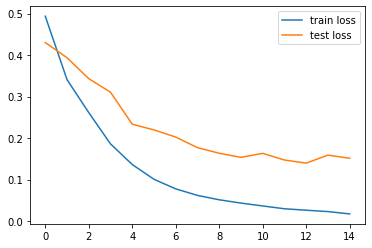

In [38]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [39]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9969, Test acc: 0.9605
